# Analyse BlueSeis BSPF Event Analysis - Velocities

In [4]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

In [5]:
from functions.compute_backazimuth import __compute_backazimuth
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [6]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [7]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

##
config['path_to_mseed'] = data_path+"BSPF/data/waveforms/ACC/"

## event selction
config['path_to_data'] = data_path+"BSPF/data/"

## output path for figures
config['output_figs'] = data_path+"BSPF/figures/velocity/"


## Load Data

In [8]:
events = obs.read_events(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_all.xml")

triggered = pd.read_pickle(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_triggered.pkl")

event_times = pd.read_pickle(config['path_to_data']+"event_selection_good.pkl")

In [9]:
num = 5

event_time = event_times.origin_time.loc[num]

event = events.filter(f"time >= {event_time}",f"time <= {event_time}")

trig = triggered[triggered.origin == event_time]

## prepare string
event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

In [10]:
st = obs.read(config['path_to_mseed']+f"*{event_time_str}*")

st.resample(40).trim(st[0].stats.starttime, st[0].stats.endtime)

st.detrend("simple")

# st.plot(equal_scale=False);

12 Trace(s) in Stream:
II.PFO.10.BHE  | 2022-12-31T12:11:26.644538Z - 2022-12-31T12:14:26.644538Z | 40.0 Hz, 7201 samples
II.PFO.10.BHN  | 2022-12-31T12:11:26.644538Z - 2022-12-31T12:14:26.644538Z | 40.0 Hz, 7201 samples
II.PFO.10.BHZ  | 2022-12-31T12:11:26.644538Z - 2022-12-31T12:14:26.644538Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJE | 2022-12-31T12:11:26.644538Z - 2022-12-31T12:14:26.644538Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJN | 2022-12-31T12:11:26.644538Z - 2022-12-31T12:14:26.644538Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJZ | 2022-12-31T12:11:26.644538Z - 2022-12-31T12:14:26.644538Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJE | 2022-12-31T12:11:26.644538Z - 2022-12-31T12:14:26.644538Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJN | 2022-12-31T12:11:26.644538Z - 2022-12-31T12:14:26.644538Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJZ | 2022-12-31T12:11:26.644538Z - 2022-12-31T12:14:26.644538Z | 40.0 Hz, 7201 samples
PY.BSPF..HJE   | 2022-12-31T12:11:26.653700Z - 2022-12-31T12:14:26.653700Z | 40.0 Hz, 

In [11]:
cut_offs = [
    (65,80), (65,80), (60,100), (60,100), (60,70),
    (60,90), (60,90), (60,90), (62,105), (65,90),
    (62,110), (65,85), (60,105),
]

st.trim(st[0].stats.starttime+cut_offs[num][0]-5, st[0].stats.endtime-cut_offs[num][1]+10);

## Velocities


In [130]:
def __compute_velocity_from_amplitude_ratio(rot0, acc0, baz=None, mode="love", win_time_s=2.0, cc_thres=0.8, overlap=0.5, flim=(None,None), plot=False):

    from scipy.stats import pearsonr
    from numpy import zeros, nan, ones, nanmean, array, nanmax, linspace, std
    from scipy import odr
    from obspy.signal.rotate import rotate_ne_rt
    from obspy.signal.cross_correlation import correlate
    from functions.compute_linear_regression import __compute_linear_regression
    import matplotlib.pyplot as plt

    npts = rot0[0].stats.npts

    df = rot0[0].stats.sampling_rate

    sta, loc = rot0[0].stats.station, rot0[0].stats.location

    ## windows
    t_win = win_time_s
    n_win = int(win_time_s*df)
    nover = int(overlap*n_win)

    ## define windows
    n, windows = 0, []
    while n < npts-n_win:
        windows.append((n,n+n_win))
        n+=n_win

    ## invert rotation rate for ADR data
    # if rot0[0].stats.station == "RPFO":
    #     rot0.select(channel="*JZ")[0].data *= -1

    ## rotate channels
    if mode == "love":
        r_acc, t_acc = rotate_ne_rt(acc0.select(channel='*N')[0].data,
                                    acc0.select(channel='*E')[0].data,
                                    baz
                                    )
        acc = t_acc
        rot = rot0.select(channel="*JZ")[0].data


    elif mode == "rayleigh":
        r_rot, t_rot = rotate_ne_rt(rot0.select(channel='*N')[0].data,
                                    rot0.select(channel='*E')[0].data,
                                    baz
                                    )
        rot = t_rot
        acc = acc0.select(channel="*HZ")[0].data

    ## add overlap
    windows_overlap = []
    for i, w in enumerate(windows):
        if i == 0:
            windows_overlap.append((w[0],w[1]+nover))
        elif i >= (len(windows)-nover):
            windows_overlap.append((w[0]-nover, w[1]))
        else:
            windows_overlap.append((w[0]-nover, w[1]+nover))

    vel, ccor = ones(len(windows_overlap))*nan, zeros(len(windows_overlap))

    ## compute crosscorrelation for each window
    for j, (w1, w2) in enumerate(windows_overlap):

        ## trying to remove very small rotation values
#         rot_win = array([r if r>5e-8 else 0 for r in rot[w1:w2]])
#         acc_win = array([a if r>5e-8 else 0 for a, r in zip(acc[w1:w2], rot[w1:w2])])
        if mode == "love":
            rot_win, acc_win = rot[w1:w2], 0.5*acc[w1:w2]
        elif mode == "rayleigh":
            rot_win, acc_win = rot[w1:w2], acc[w1:w2]

        if len(rot_win) < 10:
            print(f" -> not enough samples in window (<10)")

        ccor[j], p = pearsonr(rot_win, acc_win)
#         ccor[j] = correlate(rot_win, acc_win, 0, 'auto')[0]

        ## if cc value is above threshold perform odr to get velocity
        if ccor[j] > cc_thres:
            data = odr.RealData(rot_win, acc_win)
            out = odr.ODR(data, model=odr.unilinear)
            output = out.run()
            slope, intercept = output.beta
            vel[j] = abs(slope)


    ## define time axis
    t1 = array([w1/df for (w1, w2) in windows_overlap])
    t2 = array([w2/df for (w1, w2) in windows_overlap])

    time = array([((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap])
    terr = (t2-t1)/2


    if plot:

        cmap = plt.get_cmap("viridis", 10)

        fig, ax = plt.subplots(1,1,figsize=(15,5))

        ax.plot(array(range(len(rot)))/df, rot/max(abs(rot)), alpha=1, color="grey", label="rotation rate (rad/s)")
        ax.plot(array(range(len(acc)))/df, acc/max(abs(acc)), alpha=0.5, color="tab:red", label=r"acceleration (m/s$^2$)")
        # ax.plot(array(range(len(rot)))/df, rot, alpha=1, color="grey", label="rotation rate (rad/s)")
        # ax.plot(array(range(len(acc)))/df, acc, alpha=0.5, color="tab:red", label=r"acceleration (m/s$^2$)")


        ax.set_ylim(-1,1)
        ax.set_xlim(0, len(rot)/df)
        ax.set_xlabel("Time (s)",fontsize=14)
        ax.set_ylabel("Norm. Amplitude",fontsize=14)
        ax.grid(zorder=0)
        ax.legend(loc=2, fontsize=13)

        ax2 = ax.twinx()
        cax = ax2.scatter(time, vel, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, label="phase velocity estimate", zorder=2)
        ax2.errorbar(time, vel, xerr=terr, yerr=None, zorder=1, color="lightgrey", marker='o', markersize=2, ls="None")
        ax2.set_ylabel(r"Phase Velocity (m/s)", fontsize=14)
        ax2.set_ylim(bottom=0)
        ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
        ax2.legend(loc=1, fontsize=13)

        cbar = plt.colorbar(cax, pad=0.08)
        cbar.set_label("Cross-Correlation Coefficient", fontsize=14)

        cax.set_clip_on(False)

        if mode == "rayleigh":
            formula = r"a$_Z$/$\Omega_T$"
            ax.set_title(f"{sta}{loc} | Rayleigh ({formula}) | CC_min={cc_thres} | {flim[0]} - {flim[1]} Hz", fontsize=14)
        elif mode == "love":
            formula = r"a$_T$/2$\Omega_Z$"
            ax.set_title(f"{sta}{loc} | Love ({formula}) | CC_min={cc_thres} | {flim[0]} - {flim[1]} Hz", fontsize=14)

        out = {"time":time, "velocity":vel, "ccoef":ccor, "fig":fig}
    else:
        out = {"time":time, "velocity":vel, "ccoef":ccor}

    return out

## End of File

## BSPF and PFO

In [175]:
config['fmin'], config['fmax'] = 0.5, 2

st0 = st.copy();
st0.detrend("linear");
st0.taper(0.01);
st0.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

rot0 = st0.select(station="BSPF");
acc0 = st0.select(station="PFO*");

acc0.select(channel="*Z")[0].data *= -1
# acc0.select(channel="*N")[0].data *= -1
# acc0.select(channel="*E")[0].data *= -1

In [176]:
# rot0.select(channel="*Z")[0].data = np.roll(rot0.select(channel="*Z")[0].data, 3)
# rot0.select(channel="*N")[0].data = np.roll(rot0.select(channel="*Z")[0].data, 3)
# rot0.select(channel="*E")[0].data = np.roll(rot0.select(channel="*Z")[0].data, 3)

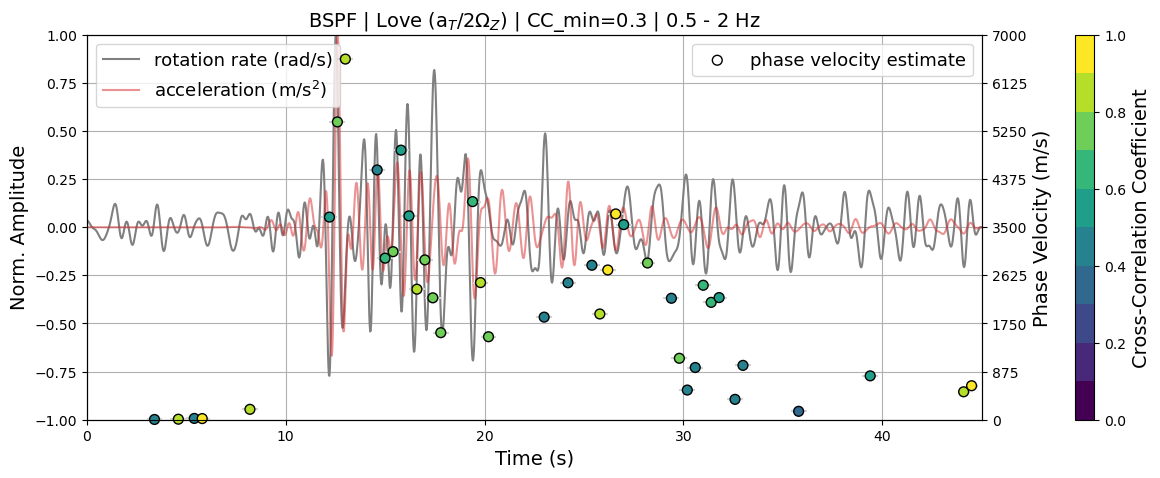

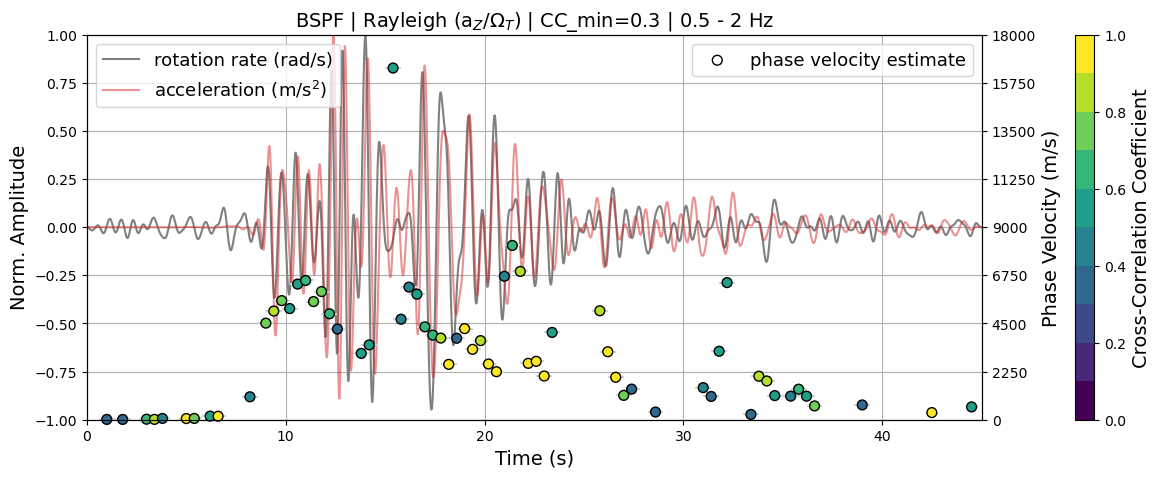

In [177]:
out = __compute_velocity_from_amplitude_ratio(
                                          rot0,
                                          acc0,
                                          baz=trig.backazimuth.iloc[0],
                                          mode="love",
                                          win_time_s=0.4,
                                          cc_thres=0.3,
                                          overlap=0.5,
                                          plot=True,
                                          flim=(config['fmin'], config['fmax']),
                                         )

# out['fig'].savefig(config['output_figs']+f"{event_time_str}_love_velocity.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

out = __compute_velocity_from_amplitude_ratio(
                                          rot0,
                                          acc0,
                                          baz=trig.backazimuth.iloc[0],
                                          mode="rayleigh",
                                          win_time_s=0.4,
                                          cc_thres=0.3,
                                          overlap=0.5,
                                          plot=True,
                                          flim=(config['fmin'], config['fmax']),
                                         )

# out['fig'].savefig(config['output_figs']+f"{event_time_str}_rayleigh_velocity.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

### ADR inner and PFO

In [156]:
# config['fmin'], config['fmax'] = 0.16, 16.5
# config['fmin'], config['fmax'] = 1, 10

st1 = st.copy();
st1.detrend("linear");
st1.taper(0.01);
st1.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

rot1 = st1.select(station="RPFO", location="in");
acc1 = st1.select(station="PFO*");

acc1.select(channel="*Z")[0].data *= -1
# acc1.select(channel="*N")[0].data *= -1
# acc1.select(channel="*E")[0].data *= -1

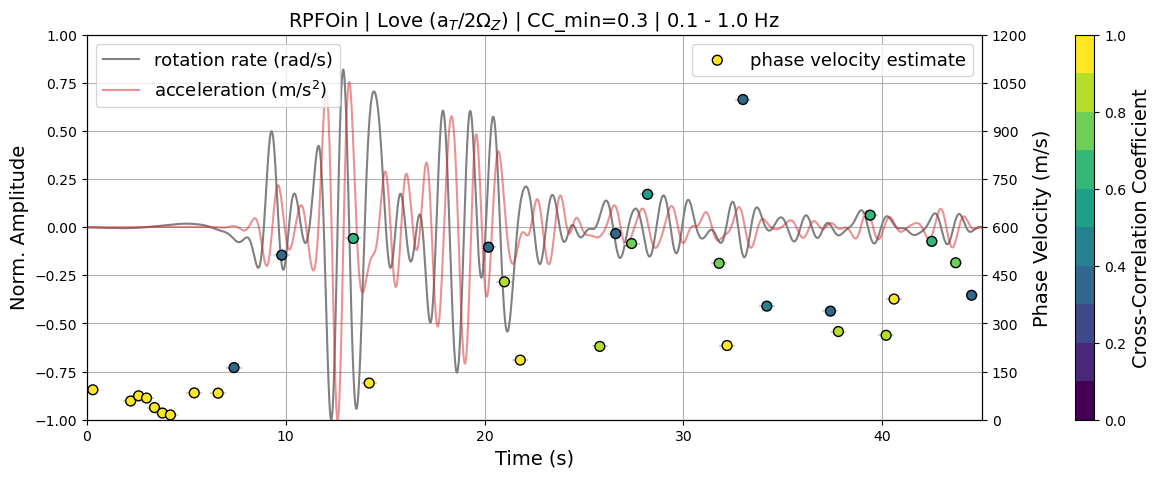

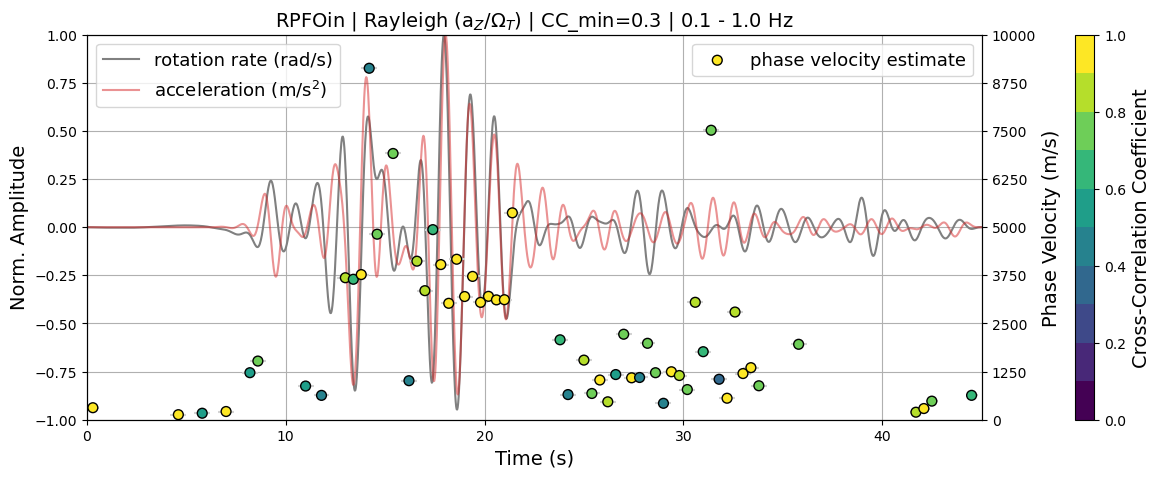

In [157]:
out = __compute_velocity_from_amplitude_ratio(rot1,
                                      acc1,
                                      baz=trig.backazimuth.iloc[0],
                                      mode="love",
                                      win_time_s=0.4,
                                      cc_thres=0.3,
                                      overlap=0.5,
                                      plot=True,
                                      flim=(config['fmin'], config['fmax']),
                                     )

out = __compute_velocity_from_amplitude_ratio(rot1,
                                      acc1,
                                      baz=trig.backazimuth.iloc[0],
                                      mode="rayleigh",
                                      win_time_s=0.4,
                                      cc_thres=0.3,
                                      overlap=0.5,
                                      plot=True,
                                      flim=(config['fmin'], config['fmax']),
                                     )

### ADR all and PFO

In [140]:
# config['fmin'], config['fmax'] = 0.02, 1.3
config['fmin'], config['fmax'] = 0.1, 1.0

st2 = st.copy();
st2.detrend("linear");
st2.taper(0.01);
st2.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

rot2 = st2.select(station="RPFO", location="al");
acc2 = st2.select(station="PFO*");

acc2.select(channel="*Z")[0].data *= -1

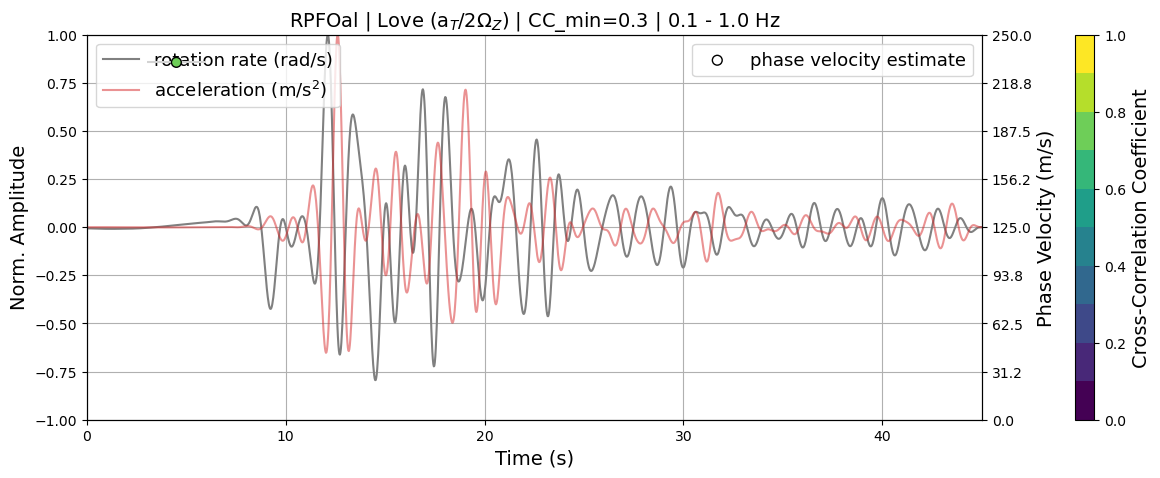

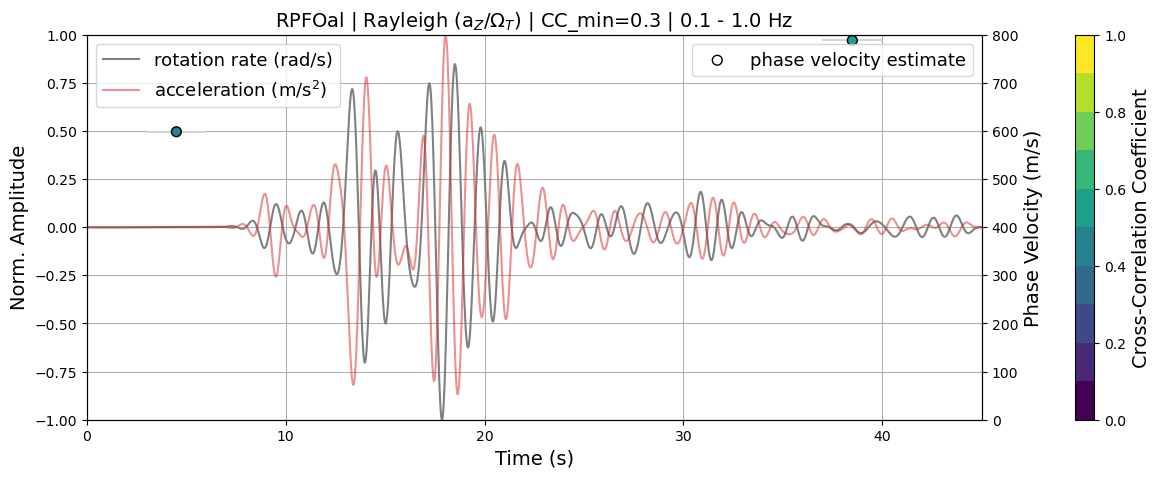

In [141]:
out = __compute_velocity_from_amplitude_ratio(rot2,
                                      acc2,
                                      baz=trig.backazimuth.iloc[0],
                                      mode="love",
                                      win_time_s=2,
                                      cc_thres=0.3,
                                      overlap=0.5,
                                      plot=True,
                                      flim=(config['fmin'], config['fmax']),
                                     )

out = __compute_velocity_from_amplitude_ratio(rot2,
                                      acc2,
                                      baz=trig.backazimuth.iloc[0],
                                      mode="rayleigh",
                                      win_time_s=2,
                                      cc_thres=0.3,
                                      overlap=0.5,
                                      plot=True,
                                      flim=(config['fmin'], config['fmax']),
                                     )

## AS LOOP

In [168]:
# ## select traces
# sta, loc = "BSPF", ""
# config['fmin'], config['fmax'] = 8, 15

# # sta, loc = "RPFO", "in"
# # config['fmin'], config['fmax'] = 8, 15

# # sta, loc = "RPFO", "al"
# # config['fmin'], config['fmax'] = 0.1, 1.0




# for i in range(0, 17):

#     event_time = event_times.origin_time.loc[i]

#     try:
#         event = events.filter(f"time >= {event_time}",f"time <= {event_time}")

#         event_time = event_times.origin_time.loc[i]

#         trig = triggered[triggered.origin == event_time]

#     except:
#         print(f" -> {i} no event")

#     ## prepare string
#     event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

#     ## load data
#     st = obs.read(config['path_to_mseed']+f"*{event_time_str}*");

#     st.detrend("simple");

#     st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);



#     rot = st.select(station=sta, location=loc);

#     acc = st.select(station="PFO*");

#     out = __compute_velocity_from_amplitude_ratio(rot,
#                                           acc,
#                                           baz=trig.backazimuth.iloc[0],
#                                           mode="love",
#                                           win_time_s=0.4,
#                                           cc_thres=0.3,
#                                           overlap=0.5,
#                                           plot=True,
#                                           flim=(config['fmin'],config['fmax']),
#                                          )

#     out['fig'].savefig(config['output_figs']+f"{event_time_str}_{sta}{loc}_love_velocity.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


#     out = __compute_velocity_from_amplitude_ratio(rot,
#                                           acc,
#                                           baz=trig.backazimuth.iloc[0],
#                                           mode="rayleigh",
#                                           win_time_s=0.4,
#                                           cc_thres=0.3,
#                                           overlap=0.5,
#                                           plot=True,
#                                           flim=(config['fmin'],config['fmax']),
#                                          )

#     out['fig'].savefig(config['output_figs']+f"{event_time_str}_{sta}{loc}_rayleigh_velocity.png", dpi=200, bbox_inches='tight', pad_inches=0.05)